In [35]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from collections import Counter
from wordcloud import WordCloud
import warnings
warnings.filterwarnings('ignore')

In [36]:
df = pd.read_csv('/content/recipes1.csv')

In [37]:
df.head()

,Title,Total Cook Time,Prep Time,Cook Time,Recipe Servings,Difficulty,Ingredients,Image Link,Link
0,Ceviche Recipe,30 mins,10 mins,20 mins,2.0,Easy,"½ KG fresh fish sea bass cut into small cubes,...",https://c.ndtvimg.com/2024-12/os1mkad8_ceviche...,https://food.ndtv.com/recipe-ceviche-958653
1,Pistachio Jam Rock Cookies Recipe,25 mins,10 mins,15 mins,2.0,Easy,"For Cookies:, 1/2 cup Sugar, 1/2 cup Butter(so...",https://c.ndtvimg.com/2024-12/1da73t0o_cookie_...,https://food.ndtv.com/recipe-pistachio-jam-roc...
2,Strawberry Pancakes Recipe,30 mins,10 mins,20 mins,2.0,Medium,"For the Pancake Batter, 200 gram all-purpose f...",https://c.ndtvimg.com/2024-12/ggdmscq8_pan_625...,https://food.ndtv.com/recipe-strawberry-pancak...
3,Gucchi Pecan Nut Pulao Recipe,55 mins,15 mins,40 mins,4.0,Easy,"6-8 dried morrels (gucchi), soaked in warm wat...",https://c.ndtvimg.com/2024-11/m1ceq2r8_nut-pul...,https://food.ndtv.com/recipe-gucchi-pecan-nut-...
4,Tadka Pecan Raita Recipe,15 mins,05 mins,10 mins,4.0,Easy,"10-15 American Pecans, blanched, 2 cups chill...",https://c.ndtvimg.com/2024-11/g3s2lj08_raita_6...,https://food.ndtv.com/recipe-tadka-pecan-raita...


In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            1097 non-null   object 
 1   Total Cook Time  1096 non-null   object 
 2   Prep Time        1096 non-null   object 
 3   Cook Time        1087 non-null   object 
 4   Recipe Servings  1046 non-null   float64
 5   Difficulty       1043 non-null   object 
 6   Ingredients      1097 non-null   object 
 7   Image Link       1097 non-null   object 
 8   Link             1097 non-null   object 
dtypes: float64(1), object(8)
memory usage: 77.3+ KB


In [39]:
# Check missing value percentages
missing = df.isnull().mean().round(4) * 100
print("Missing Values (%):\n", missing[missing >= 0])

Missing Values (%):
 Title              0.00
Total Cook Time    0.09
Prep Time          0.09
Cook Time          0.91
Recipe Servings    4.65
Difficulty         4.92
Ingredients        0.00
Image Link         0.00
Link               0.00
dtype: float64


In [40]:
# Fill Difficulty with 'Unknown'
df['Difficulty'].fillna('Unknown', inplace=True)

# Fill Recipe Servings with mode
df['Recipe Servings'].fillna(df['Recipe Servings'].mode()[0], inplace=True)

# Drop rows where key times are missing
df.dropna(subset=['Total Cook Time', 'Prep Time', 'Cook Time'], inplace=True)

In [41]:
# --- Time Conversion ---
def time_to_minutes(text):
    if pd.isnull(text): return 0
    text = text.lower()
    minutes = re.findall(r'(\d+)\s*mins?', text)
    hours = re.findall(r'(\d+)\s*hrs?', text)
    return sum([int(h)*60 for h in hours]) + sum([int(m) for m in minutes])

df['Total Cook Time (mins)'] = df['Total Cook Time'].apply(time_to_minutes)
df['Prep Time (mins)'] = df['Prep Time'].apply(time_to_minutes)
df['Cook Time (mins)'] = df['Cook Time'].apply(time_to_minutes)

# --- Feature Engineering ---
df['Is Easy'] = df['Difficulty'].apply(lambda x: 1 if str(x).lower().strip() == 'easy' else 0)

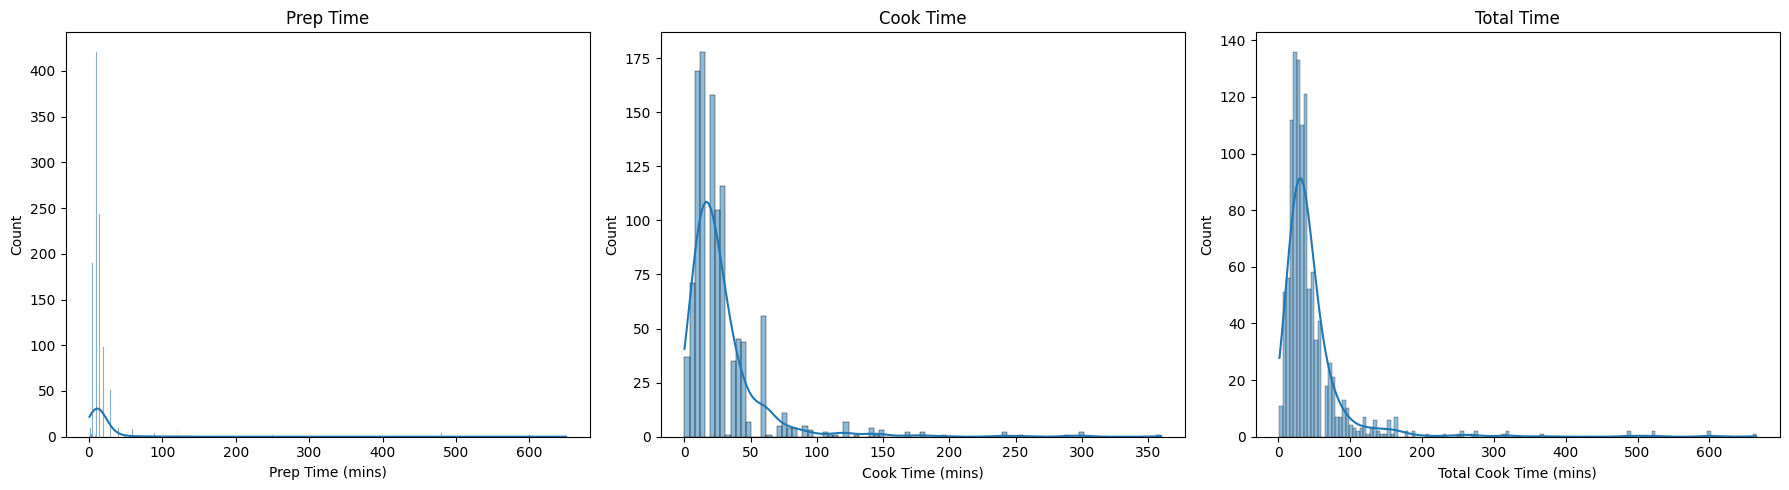

In [42]:
# Time Distributions
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
sns.histplot(df['Prep Time (mins)'], ax=axs[0], kde=True).set(title='Prep Time')
sns.histplot(df['Cook Time (mins)'], ax=axs[1], kde=True).set(title='Cook Time')
sns.histplot(df['Total Cook Time (mins)'], ax=axs[2], kde=True).set(title='Total Time')
plt.tight_layout()
plt.show()

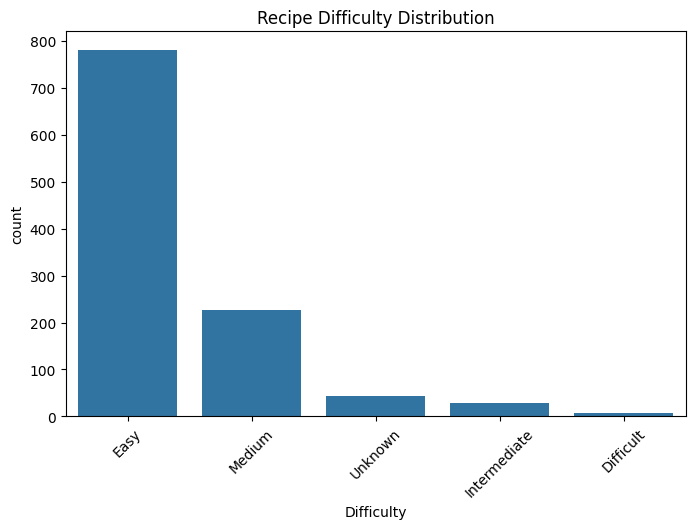

In [43]:

# Difficulty Distribution
plt.figure(figsize=(8,5))
sns.countplot(data=df, x='Difficulty', order=df['Difficulty'].value_counts().index)
plt.title('Recipe Difficulty Distribution')
plt.xticks(rotation=45)
plt.show()

In [45]:
df['Ingredients'][0]

'½ KG fresh fish sea bass cut into small cubes, 1 cup fresh lime juice (about 8-10 limes), 1/2 cup fresh lemon juice (about 4-5 lemons), 1 jalapeño, seeded and finely diced, 1 cup Slice onions, 1/2 cup chopped cilantro, Salt and pepper to taste, Optional: diced avocado, cucumber, or mango for extra flavour'

In [46]:
# Load the spaCy English model
nlp = spacy.load('en_core_web_sm')

# Words to be removed from the ingredient lists
remove_words = ['tsp', 'tbsp', 'ml', 'gm', 'cups', 'boiled', 'chopped', 'sliced', 'crushed', 'powder', 'salt', 'butter', 'oil','cup','pinched','mashed','melted','allpurpose','ripe','baking','cooked','leftover','hot','diced','paste','gms','pinch','optional','large','small']

# Stopwords that are not relevant for ingredient lists
stopwords = ['and', 'with', 'in', 'for', 'of', 'to', 'from', 'a', 'the', 'on', 'at', 'by','or']

# Function to clean the ingredient string
def clean_ingredients(ingredient_str):
    # Remove digits
    ingredient_str = re.sub(r'\d+', '', ingredient_str)
    # Remove punctuation
    ingredient_str = re.sub(r'[^\w\s]', '', ingredient_str)

    # Split the ingredients into tokens
    tokens = ingredient_str.split()
    # Remove unwanted words
    cleaned_tokens = [token for token in tokens if token not in remove_words and token not in stopwords]

    return ' '.join(cleaned_tokens)


# Applying the cleaning function to the 'Ingredients' column
df['Core_Ingredients'] = df['Ingredients'].apply(clean_ingredients)

# Function to extract nouns from a given text using spaCy
def extract_nouns(text):
    doc = nlp(text)
    # Extract nouns and proper nouns
    nouns = {token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']}
    return ' '.join(nouns)

# Replace the Core_Ingredients column with extracted nouns
df['Core_Ingredients'] = df['Core_Ingredients'].apply(extract_nouns)



In [50]:
df.head()

,Title,Total Cook Time,Prep Time,Cook Time,Recipe Servings,Difficulty,Ingredients,Image Link,Link,Total Cook Time (mins),Prep Time (mins),Cook Time (mins),Is Easy,Core_Ingredients,Ingredient_Vector
0,Ceviche Recipe,30 mins,10 mins,20 mins,2.0,Easy,"½ KG fresh fish sea bass cut into small cubes,...",https://c.ndtvimg.com/2024-12/os1mkad8_ceviche...,https://food.ndtv.com/recipe-ceviche-958653,30,10,20,1,taste flavour lemons cut jalapeño KG Salt cube...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,Pistachio Jam Rock Cookies Recipe,25 mins,10 mins,15 mins,2.0,Easy,"For Cookies:, 1/2 cup Sugar, 1/2 cup Butter(so...",https://c.ndtvimg.com/2024-12/1da73t0o_cookie_...,https://food.ndtv.com/recipe-pistachio-jam-roc...,25,10,15,1,wash Jam Pistachios ½ Cookies essence Butterso...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,Strawberry Pancakes Recipe,30 mins,10 mins,20 mins,2.0,Medium,"For the Pancake Batter, 200 gram all-purpose f...",https://c.ndtvimg.com/2024-12/ggdmscq8_pan_625...,https://food.ndtv.com/recipe-strawberry-pancak...,30,10,20,0,milk strawberries eggs lemon cream Pancake gra...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,Gucchi Pecan Nut Pulao Recipe,55 mins,15 mins,40 mins,4.0,Easy,"6-8 dried morrels (gucchi), soaked in warm wat...",https://c.ndtvimg.com/2024-11/m1ceq2r8_nut-pul...,https://food.ndtv.com/recipe-gucchi-pecan-nut-...,55,15,40,1,taste American cinnamon peppercorns strands mo...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,Tadka Pecan Raita Recipe,15 mins,05 mins,10 mins,4.0,Easy,"10-15 American Pecans, blanched, 2 cups chill...",https://c.ndtvimg.com/2024-11/g3s2lj08_raita_6...,https://food.ndtv.com/recipe-tadka-pecan-raita...,15,5,10,1,taste American asafoetida mustard chillies yog...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [48]:
all_ingredients = []
for ingredients in df['Core_Ingredients']:
    items = [ingredient.strip() for ingredient in ingredients.split()]
    all_ingredients.extend(items)

vocab = sorted(list(set(all_ingredients)))

print("Size of Vocabulary:", len(vocab))

Size of Vocabulary: 2115


In [49]:
def vectorize_ingredients(ingredient_str, vocab):

    vector = [0] * len(vocab)

    ingredients = [ingredient.strip() for ingredient in ingredient_str.split()]

    for ingredient in ingredients:
        if ingredient in vocab:
            vector[vocab.index(ingredient)] = 1

    return vector

df['Ingredient_Vector'] = df['Core_Ingredients'].apply(lambda x: vectorize_ingredients(x, vocab))

In [ ]:
import pickle

# Save your vocabulary and any other models if necessary
with open('recipe_recommendation_model.pkl', 'wb') as f:
    pickle.dump(vocab, f)

# Optionally save the DataFrame if needed
df.to_csv('recipes_processed1.csv', index=False)